In [1]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import networkx as nx
import random
import os


from torch.distributions import Categorical, Bernoulli


import json

from agents.option_critic import OptionCriticFeatures
from agents.option_critic_nn import OptionCriticNeuralNetwork
from agents.option_networks import TerminationFunctionNetwork
from agents.option_networks import ReluNetwork
from agents.option_networks import QNetwork

from utils import utils


/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix):
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    df_multiple_episodes = None
    # df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def get_obs(df, index):
    current_option = df.option.to_list()[index]
    total_observation = []
    unnested_obs = {}
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():
    #   current_time = observation_dict["current_time"]
        phase_ids = observation_dict["phase_ids"]
        min_green = observation_dict["min_green"]
        density = observation_dict["density"]
        queue = observation_dict["queue"]
        delta_queue = observation_dict["delta_queue"]
        observation = phase_ids + min_green + density + queue + delta_queue
        total_observation.extend(observation)
        for key, value in observation_dict.items():
            if isinstance(value, list):
                for index, item in enumerate(value):
                    unnested_obs[f"{tf_id}_{key}_{index}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)
    return total_observation, current_option, unnested_obs

def get_random_obs(df):
    index = random.randrange(df.shape[0])
    return get_obs(df, index)

def prep_state(obs):
    """Convert the provided observation to a tensor

    Args:
        obs (Any): Obs provided by the environment
    """

    # Unnest observation
    obs_array = []
    if isinstance(obs, dict):
        for _, obs_arr in obs.items():
            obs_array.extend(obs_arr)
    else:
        obs_array.extend(obs)


    # include option information
    # Simplified to make it easier to manage
    # encoded_option = np.zeros(self.num_options)
    # encoded_option[self.current_option] = 1
    # obs = np.append(obs, encoded_option)

    # Convert to tensor
    obs_tensor = to_tensor(obs_array)
    if obs_tensor.ndim < 4:
        obs_tensor = obs_tensor.unsqueeze(0)
    obs_tensor = obs_tensor.to("cpu")
    return obs_tensor


In [3]:
BASE_FOLDER = './evaluations'
N_OPTIONS = 3
TRAFFIC = "custom-2way-single-intersection3"
MODEL = f"option_critic_nn_100000_steps_curriculum_3_options_custom-2way-single-intersection3_100000_steps"
PREFIX = f"{MODEL}_{TRAFFIC}"                                              

In [4]:
df_single_episode, _ = load_data(PREFIX)

model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = model_params['Q']
termination_network_params = model_params['terminations']

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")

termination_model.load_state_dict(termination_network_params)

q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")

q_model.load_state_dict(q_model_params)


/tmp/ipykernel_11542/660746802.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(


<All keys matched successfully>

<Axes: xlabel='step'>

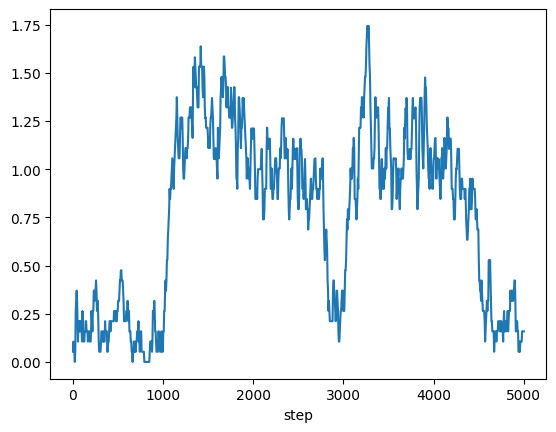

In [5]:
df_single_episode.lane_density.plot()

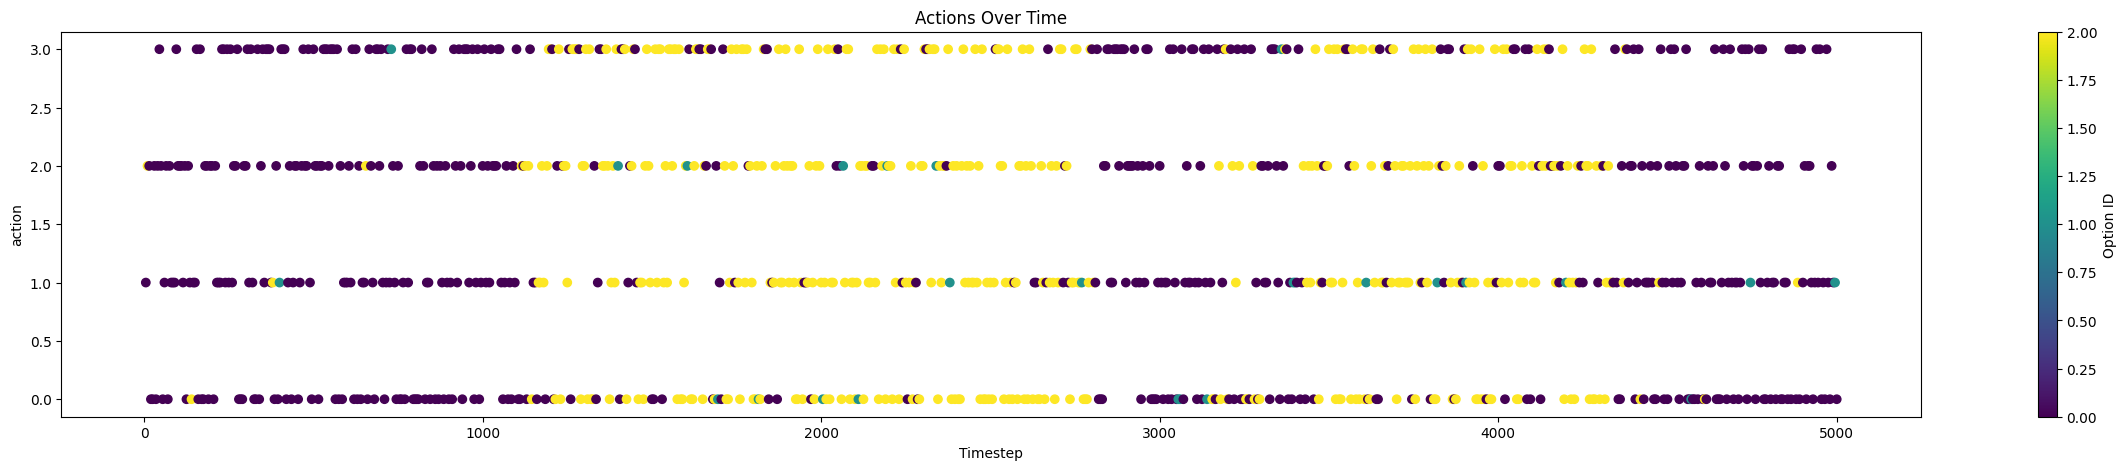

In [7]:
plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

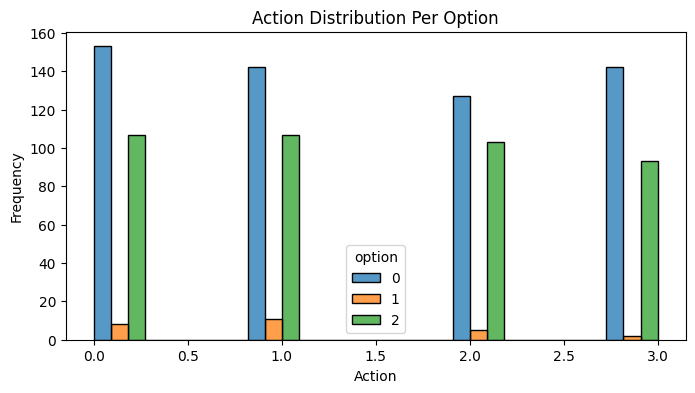

In [8]:
plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="action", hue="option", multiple="dodge", palette="tab10")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

In [11]:
df_single_episode.termination_prob.to_list()

[0.9315056800842284,
 0.9494047164916992,
 0.9898055791854858,
 0.9817346930503844,
 0.9924396276474,
 0.985228419303894,
 0.99027281999588,
 0.9904739260673524,
 0.9829880595207214,
 0.9933184385299684,
 0.9938600063323976,
 0.9864023327827454,
 0.9903072118759156,
 0.9818235635757446,
 0.9924684166908264,
 0.99281245470047,
 0.9843288660049438,
 0.9863648414611816,
 0.9833042621612548,
 0.970999002456665,
 0.9895315170288086,
 0.9839770197868348,
 0.9931407570838928,
 0.9851166605949402,
 0.9870109558105468,
 0.9698120951652528,
 0.9881437420845032,
 0.9748674631118774,
 0.9856408834457396,
 0.9841639399528505,
 0.9841545820236206,
 0.972505509853363,
 0.9903725385665894,
 0.9921038150787354,
 0.9829344153404236,
 0.9906855225563048,
 0.982637584209442,
 0.9930421113967896,
 0.9853743314743042,
 0.9902209043502808,
 0.9816176295280457,
 0.9923998713493348,
 0.9928001165390016,
 0.9842997789382936,
 0.9863046407699584,
 0.984274446964264,
 0.9739257097244264,
 0.9910818338394164,
 0.9

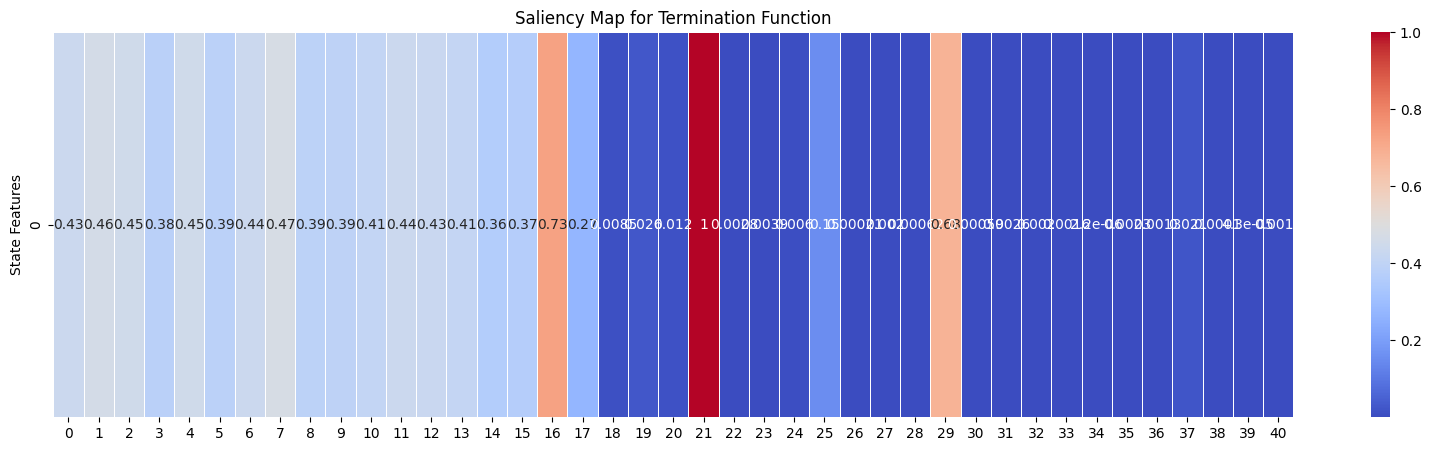

In [33]:
obs, current_option, unnested_dict = get_random_obs(df_single_episode)
state = prep_state(obs)
state = state.clone().detach().requires_grad_(True)
# Forward pass
termination_prob = termination_model(state)[:, current_option]

# Compute gradients w.r.t input state
termination_prob.backward()

# Get absolute gradient values (saliency)
saliency = state.grad.abs().detach().numpy()

# Normalize for visualization
saliency /= saliency.max()

# Plot saliency map
plt.figure(figsize=(20, 5))
sns.heatmap(saliency.reshape(1, -1), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Saliency Map for Termination Function")
plt.ylabel("State Features")
plt.show()

In [ ]:
for index, key in enumerate(unnested_dict):
    print(index, key)

In [40]:
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    state = prep_state(obs)
    print(index, current_option, df_single_episode.termination_prob.to_list()[index], q_model(state), termination_model(state))

0 2 0.9502043128013612 tensor([[-478.1990, -482.2177, -479.3328]], grad_fn=<AddmmBackward0>) tensor([[3.7152, 3.1767, 4.0752]], grad_fn=<AddmmBackward0>)
1 2 0.9713730812072754 tensor([[-470.6315, -477.7524, -474.4832]], grad_fn=<AddmmBackward0>) tensor([[4.7154, 3.9667, 5.1681]], grad_fn=<AddmmBackward0>)
2 0 0.9911234378814696 tensor([[-471.7423, -477.5246, -474.2773]], grad_fn=<AddmmBackward0>) tensor([[3.8588, 3.2761, 4.2321]], grad_fn=<AddmmBackward0>)
3 0 0.9817360043525696 tensor([[-476.7942, -486.7111, -482.9829]], grad_fn=<AddmmBackward0>) tensor([[4.2094, 3.5584, 4.6150]], grad_fn=<AddmmBackward0>)
4 0 0.9862304329872132 tensor([[-481.9530, -488.9064, -485.6430]], grad_fn=<AddmmBackward0>) tensor([[3.9336, 3.3487, 4.3136]], grad_fn=<AddmmBackward0>)
5 0 0.9782877564430236 tensor([[-458.0172, -465.3253, -462.0995]], grad_fn=<AddmmBackward0>) tensor([[4.6826, 3.9418, 5.1322]], grad_fn=<AddmmBackward0>)
6 0 0.990259289741516 tensor([[-472.3921, -478.9815, -475.6533]], grad_fn=<A

194 0 0.9759044051170348 tensor([[-503.7919, -513.5397, -509.6604]], grad_fn=<AddmmBackward0>) tensor([[4.2587, 3.5980, 4.6689]], grad_fn=<AddmmBackward0>)
195 0 0.9864656329154968 tensor([[-513.3923, -522.4179, -518.5701]], grad_fn=<AddmmBackward0>) tensor([[3.6707, 3.1316, 4.0262]], grad_fn=<AddmmBackward0>)
196 0 0.976126194000244 tensor([[-537.4914, -546.0312, -542.0755]], grad_fn=<AddmmBackward0>) tensor([[4.3396, 3.6652, 4.7574]], grad_fn=<AddmmBackward0>)
197 0 0.9867368340492249 tensor([[-530.3815, -537.3608, -533.7854]], grad_fn=<AddmmBackward0>) tensor([[4.0739, 3.4617, 4.4671]], grad_fn=<AddmmBackward0>)
198 0 0.9803413152694702 tensor([[-478.7282, -486.8103, -483.3733]], grad_fn=<AddmmBackward0>) tensor([[4.7365, 3.9839, 5.1911]], grad_fn=<AddmmBackward0>)
199 0 0.9910345673561096 tensor([[-459.8272, -466.3513, -463.0862]], grad_fn=<AddmmBackward0>) tensor([[3.8401, 3.2628, 4.2117]], grad_fn=<AddmmBackward0>)
200 0 0.9813994765281676 tensor([[-485.3566, -495.6748, -491.8396

402 0 0.979791820049286 tensor([[-653.0580, -658.6584, -654.5222]], grad_fn=<AddmmBackward0>) tensor([[4.7520, 3.9996, 5.2081]], grad_fn=<AddmmBackward0>)
403 0 0.9909089207649232 tensor([[-617.7207, -623.9035, -619.8995]], grad_fn=<AddmmBackward0>) tensor([[4.7417, 3.9911, 5.1968]], grad_fn=<AddmmBackward0>)
404 0 0.9913522005081176 tensor([[-634.6735, -639.5157, -635.4489]], grad_fn=<AddmmBackward0>) tensor([[3.8455, 3.2711, 4.2173]], grad_fn=<AddmmBackward0>)
405 2 0.9878480434417723 tensor([[-628.5258, -636.1816, -631.8095]], grad_fn=<AddmmBackward0>) tensor([[4.2311, 3.5838, 4.6387]], grad_fn=<AddmmBackward0>)
406 0 0.98610919713974 tensor([[-638.1304, -643.3973, -639.2263]], grad_fn=<AddmmBackward0>) tensor([[3.7203, 3.1748, 4.0807]], grad_fn=<AddmmBackward0>)
407 0 0.9753995537757874 tensor([[-677.6284, -685.1783, -680.5544]], grad_fn=<AddmmBackward0>) tensor([[4.2464, 3.5917, 4.6555]], grad_fn=<AddmmBackward0>)
408 0 0.9863031506538392 tensor([[-672.8629, -677.0737, -672.8553]]

627 0 0.98249751329422 tensor([[-507.2645, -515.6992, -511.9422]], grad_fn=<AddmmBackward0>) tensor([[4.3096, 3.6407, 4.7246]], grad_fn=<AddmmBackward0>)
628 0 0.9871456623077391 tensor([[-517.0042, -525.6121, -521.7700]], grad_fn=<AddmmBackward0>) tensor([[4.3131, 3.6436, 4.7284]], grad_fn=<AddmmBackward0>)
629 2 0.991236925125122 tensor([[-509.7774, -516.3900, -512.7988]], grad_fn=<AddmmBackward0>) tensor([[3.8428, 3.2660, 4.2147]], grad_fn=<AddmmBackward0>)
630 0 0.9781737923622132 tensor([[-511.3741, -520.7015, -516.8214]], grad_fn=<AddmmBackward0>) tensor([[4.3538, 3.6702, 4.7730]], grad_fn=<AddmmBackward0>)
631 0 0.9876777529716492 tensor([[-511.9677, -519.2343, -515.5943]], grad_fn=<AddmmBackward0>) tensor([[3.6417, 3.0992, 3.9948]], grad_fn=<AddmmBackward0>)
632 0 0.9771286249160768 tensor([[-556.0255, -562.6528, -558.8252]], grad_fn=<AddmmBackward0>) tensor([[4.2407, 3.5721, 4.6502]], grad_fn=<AddmmBackward0>)
633 0 0.9860010743141174 tensor([[-552.7095, -559.2246, -555.4281]]

862 0 0.9895049333572388 tensor([[-658.1104, -662.3024, -658.1953]], grad_fn=<AddmmBackward0>) tensor([[4.2774, 3.5923, 4.6908]], grad_fn=<AddmmBackward0>)
863 0 0.9847241640090942 tensor([[-672.7991, -679.2462, -674.8319]], grad_fn=<AddmmBackward0>) tensor([[5.0188, 4.1797, 5.5004]], grad_fn=<AddmmBackward0>)
864 0 0.9933426976203918 tensor([[-671.2935, -675.1520, -671.2268]], grad_fn=<AddmmBackward0>) tensor([[4.7875, 4.0046, 5.2476]], grad_fn=<AddmmBackward0>)
865 0 0.9906814694404602 tensor([[-646.2556, -650.6214, -646.7421]], grad_fn=<AddmmBackward0>) tensor([[5.4555, 4.5333, 5.9776]], grad_fn=<AddmmBackward0>)
866 0 0.9954894185066224 tensor([[-673.6890, -677.0909, -673.0259]], grad_fn=<AddmmBackward0>) tensor([[4.5303, 3.7934, 4.9664]], grad_fn=<AddmmBackward0>)
867 2 0.9941917061805724 tensor([[-666.8610, -673.3621, -668.9620]], grad_fn=<AddmmBackward0>) tensor([[4.9075, 4.0989, 5.3785]], grad_fn=<AddmmBackward0>)
868 0 0.9928845167160034 tensor([[-661.1926, -665.3126, -661.396

In [ ]:
def create_feature_df(df):
    feature_list = []
    for obs_item in df.obs.to_list():
        unnested_obs = {}
        for tf_id, observation_dict in json.loads(obs_item).items():
            for key, value in observation_dict.items():
                if isinstance(value, list):
                    for index, item in enumerate(value):
                        unnested_obs[f"{tf_id}_{key}_{index}"] = item
                else:
                    unnested_obs[f"{tf_id}_{key}"] = value
                    
        feature_list.append(unnested_obs)
    return pd.DataFrame(feature_list)

features = create_feature_df(df_single_episode)

def f(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = termination_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer = shap.KernelExplainer(f, features.iloc[:50, :])
shap_values = explainer.shap_values(features.iloc[:, :], nsamples=50)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features)

In [ ]:
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values, features)

In [ ]:
##########
# Backup #
##########

In [ ]:
states = df_single_episode.obs.to_list()
options = df_single_episode.option.to_list()
n = df_single_episode.shape[0]
G = nx.DiGraph()

# Add nodes with positions
node_colors = []
for i in range(n):
    G.add_node(states[i], option=options[i])
    node_colors.append(options[i])

# Add directed edges based on actions
for i in range(n - 1):
    G.add_edge(i, i + 1, action=i)

# Draw graph
plt.figure(figsize=(8, 6))
print("Drawing graph")
nx.draw(
    G, with_labels=True,cmap=plt.cm.viridis,
    edge_color="gray", node_size=300, font_size=8, font_color="white",
    arrows=True, arrowsize=10
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)

plt.title("State-Action Network with Termination States")
plt.show()

In [ ]:
model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = {}
termination_network_params = {}

for key, value in model_params.items():
    if key.startswith('Q'):
        q_model_params[key] = value
    elif key.startswith("terminations"):
        termination_network_params[key] = value
    else:
        print(f"Unknown key {key}")

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")
q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")